In [29]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

In [2]:
# # Add your token below
# service = QiskitRuntimeService(channel="ibm_quantum")

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

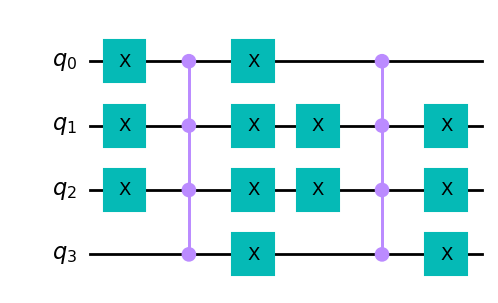

In [20]:
marked_states = ["1000", "0001"]
oracle = grover_oracle(marked_states)
oracle.draw("mpl")

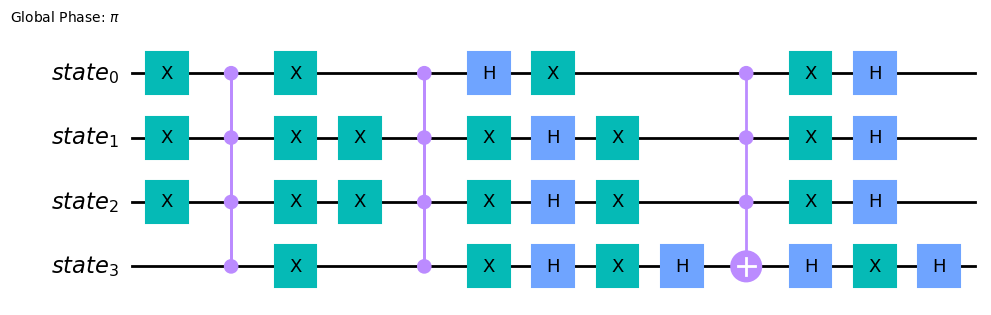

In [21]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl")

In [22]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

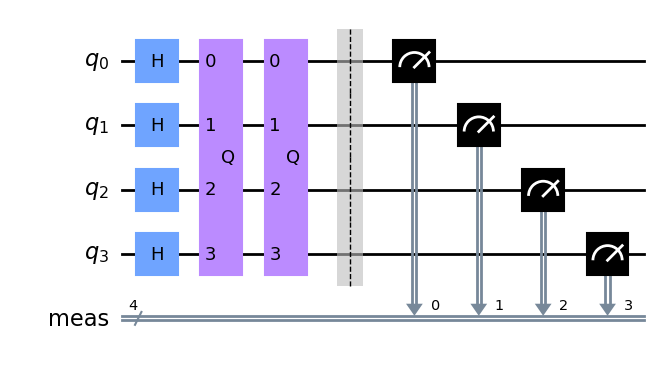

In [23]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw("mpl")

In [24]:
# # Select the simulator with the fewest number of jobs in the queue
# backend_simulator = service.least_busy(simulator=True, operational=True)
# backend_simulator.name

In [25]:
simulator =Aer.get_backend('statevector_simulator')
result = execute(qc, backend = simulator, shots = 1024).result()

counts = result.get_counts()
state = result.get_statevector()

In [26]:
counts

{'0000': 3,
 '1000': 482,
 '1100': 2,
 '0011': 5,
 '0001': 482,
 '1111': 4,
 '1011': 5,
 '0100': 2,
 '0111': 5,
 '1110': 5,
 '1010': 6,
 '0101': 4,
 '1101': 8,
 '1001': 4,
 '0110': 3,
 '0010': 4}

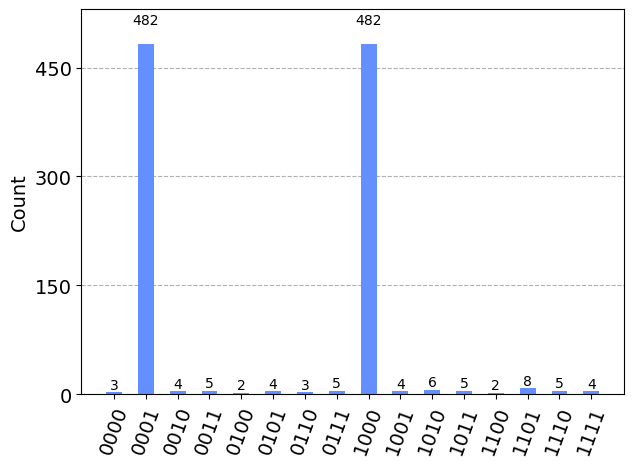

In [32]:
plot_histogram(counts)

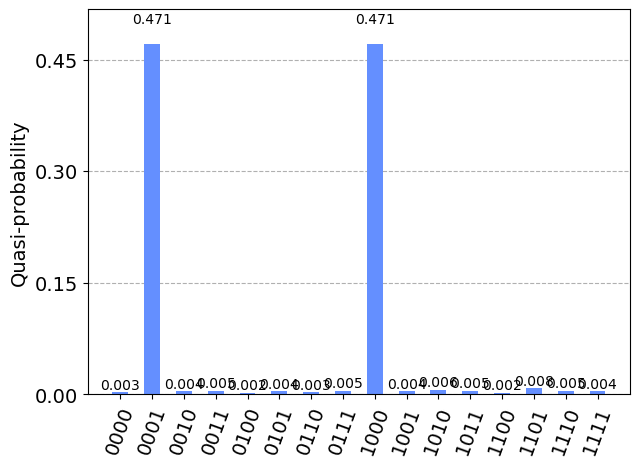

In [33]:
plot_distribution(counts)